In [ ]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/split_3.csv')
df.head(10)


,time_idx,series,node_values
0,1,0,-1
1,2,0,-2
2,3,0,-3
3,4,0,-4
4,5,0,-5
5,6,0,-6
6,7,0,-7
7,8,0,-8
8,9,0,-9
9,10,0,-10


In [ ]:
# df.describe()

In [ ]:
# from pandas import DataFrame
# from pandas import concat


# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	"""
# 	Frame a time series as a supervised learning dataset.
# 	Arguments:
# 		data: Sequence of observations as a list or NumPy array.
# 		n_in: Number of lag observations as input (X).
# 		n_out: Number of observations as output (y).
# 		dropnan: Boolean whether or not to drop rows with NaN values.
# 	Returns:
# 		Pandas DataFrame of series framed for supervised learning.
# 	"""
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = DataFrame(data)
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df.shift(-i))
# 		if i == 0:
# 			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
# 		else:
# 			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# 	# put it all together
# 	agg = concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	# if dropnan:
# 	# 	agg.dropna(inplace=True)
# 	return agg


# # raw = DataFrame()
# # raw = pd.read_csv('/content/pollution1.csv')
# # values = raw.values
# # data = series_to_supervised(values, 1, 7)
# # print(data)

In [ ]:
# df_node = df['Node_value','']
# print(df_node.shape)

In [ ]:

	
# from statsmodels.tsa.seasonal import seasonal_decompose
# from matplotlib import pyplot

# result = seasonal_decompose(df['node_values'],model='additive', freq= 2)
# result.plot()
# pyplot.show()

# Data cleansing

In [ ]:
columns_to_keep = ['node_values']
df = df[columns_to_keep]
# df['value'] = df['value'].apply(lambda x: x*1000)
df.index.names = ['time_idx']
df.sort_index(inplace=True)
print('Total rows: {}'.format(len(df)))
df.head()

Total rows: 5209


,node_values
time_idx,
0,-1
1,-2
2,-3
3,-4
4,-5


In [ ]:
# df.describe()

In [ ]:
# df.plot()

Null values?

In [ ]:
df.isnull().sum()

node_values    0
dtype: int64

In [ ]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [ ]:
print(df[df.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [ ]:
# df.hist(bins=10)

In [ ]:
len(df[df['node_values'] == 0])

0

# Scaled data

In [ ]:
print('Min', np.min(df))
print('Max', np.max(df))

Min node_values   -3018
dtype: int64
Max node_values   -1
dtype: int64


We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [ ]:
dataset = df.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset) 

In [ ]:
# print('Min', np.min(scaled))
# print('Max', np.max(scaled))

In [ ]:
# print(scaled[:10])

# Create the RNN

A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 70% of the observations that we can use to train our model, leaving the remaining 30% for testing the model.
Split into train and test sets

In [ ]:
train_size = int(len(scaled) * 0.8074)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 4205
test: 1004


In [ ]:
# print(len(test))

convert an array of values into a dataset matrix

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the energy quantity at a given time (t) and Y is the qty of energy at the next time (t + 1).

In [ ]:
def create_dataset(dataset, look_back=2):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

reshape into X=t and Y=t+1

In [ ]:
look_back = 2
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

Streaming output truncated to the last 5000 lines.
1
X 1 to 3
[0.187935   0.18760353]
Y 3
0.18727207
2
X 2 to 4
[0.18760353 0.18727207]
Y 4
0.18694061
3
X 3 to 5
[0.18727207 0.18694061]
Y 5
0.18727207
4
X 4 to 6
[0.18694061 0.18727207]
Y 6
0.18694061
5
X 5 to 7
[0.18727207 0.18694061]
Y 7
0.18727207
6
X 6 to 8
[0.18694061 0.18727207]
Y 8
0.18694061
7
X 7 to 9
[0.18727207 0.18694061]
Y 9
0.18660915
8
X 8 to 10
[0.18694061 0.18660915]
Y 10
0.18627769
9
X 9 to 11
[0.18660915 0.18627769]
Y 11
0.18594629
10
X 10 to 12
[0.18627769 0.18594629]
Y 12
0.18561482
11
X 11 to 13
[0.18594629 0.18561482]
Y 13
0.18594629
12
X 12 to 14
[0.18561482 0.18594629]
Y 14
0.18561482
13
X 13 to 15
[0.18594629 0.18561482]
Y 15
0.18594629
14
X 14 to 16
[0.18561482 0.18594629]
Y 16
0.18627769
15
X 15 to 17
[0.18594629 0.18627769]
Y 17
0.18660915
16
X 16 to 18
[0.18627769 0.18660915]
Y 18
0.18627769
17
X 17 to 19
[0.18660915 0.18627769]
Y 19
0.18594629
18
X 18 to 20
[0.18627769 0.18594629]
Y 20
0.18627769
19
X 19 t

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].


reshape input to be [samples, time steps, features]

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(4202, 2, 1)
(1001, 2, 1)


In [ ]:
import tensorflow as tf


In [ ]:
from numpy.random import seed
seed(1)


The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.


create and fit the LSTM network

In [ ]:
batch_size = 1
model = Sequential()
model.add(LSTM(units=10,activation='relu', batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(units=4))
model.add(Dense(units=2))
model.add(Dense(1))

# model = Sequential()#Adding the first LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True, batch_input_shape=(batch_size, look_back, 1), stateful=True))
# model.add(Dropout(0.2))# Adding a second LSTM layer and some Dropout regularisation
# # model.add(LSTM(units = 50, return_sequences = True))
# # model.add(Dropout(0.2))# Adding a third LSTM layer and some Dropout regularisation
# # model.add(LSTM(units = 50, return_sequences = True))
# # model.add(Dropout(0.2))# Adding a fourth LSTM layer and some Dropout regularisation
# # model.add(LSTM(units = 50))
# # model.add(Dropout(0.2))# Adding the output layer
# model.add(Dense(units=10))
# model.add(Dense(units = 1))


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train,epochs=45, batch_size=batch_size, verbose=1, shuffle=True)



Epoch 1/45
4202/4202 [==============================] - 42s 4ms/step - loss: 0.0282 - accuracy: 0.0000e+00
Epoch 2/45
4202/4202 [==============================] - 19s 4ms/step - loss: 1.4387e-04 - accuracy: 0.0000e+00
Epoch 3/45
4202/4202 [==============================] - 18s 4ms/step - loss: 2.9806e-05 - accuracy: 0.0000e+00
Epoch 4/45
4202/4202 [==============================] - 18s 4ms/step - loss: 2.0892e-05 - accuracy: 0.0000e+00
Epoch 5/45
4202/4202 [==============================] - 19s 4ms/step - loss: 1.8661e-05 - accuracy: 0.0000e+00
Epoch 6/45
4202/4202 [==============================] - 19s 4ms/step - loss: 1.7365e-05 - accuracy: 0.0000e+00
Epoch 7/45
4202/4202 [==============================] - 19s 4ms/step - loss: 1.6651e-05 - accuracy: 0.0000e+00
Epoch 8/45
4202/4202 [==============================] - 19s 4ms/step - loss: 1.8130e-05 - accuracy: 0.0000e+00
Epoch 9/45
4202/4202 [==============================] - 19s 4ms/step - loss: 1.5586e-05 - accuracy: 0.0000e+00
Epoch

In [ ]:
model.save('/content/split_1_spit-3')

INFO:tensorflow:Assets written to: /content/split_1_spit-3/assets


In [ ]:
model.save_weights('my_model_weights_split_3.h5') 

In [ ]:
 from keras.models import load_model

    


In [ ]:
model.save('my_model_split3.h5')  # creates a HDF5 file 'my_model.h5'
    # del model  # deletes the existing model

    # returns a compiled model
    # identical to the previous one


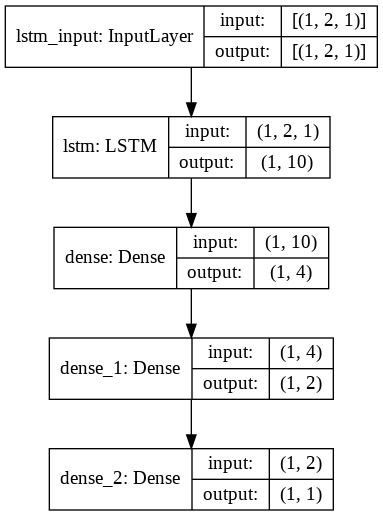

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True,show_layer_names=True,)

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

Make preditions

In [ ]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.45 RMSE
Test Score: 30.22 RMSE


In [ ]:


def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [ ]:
smape(y_test[0], testPredict[:,0])

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.


shift train predictions for plotting

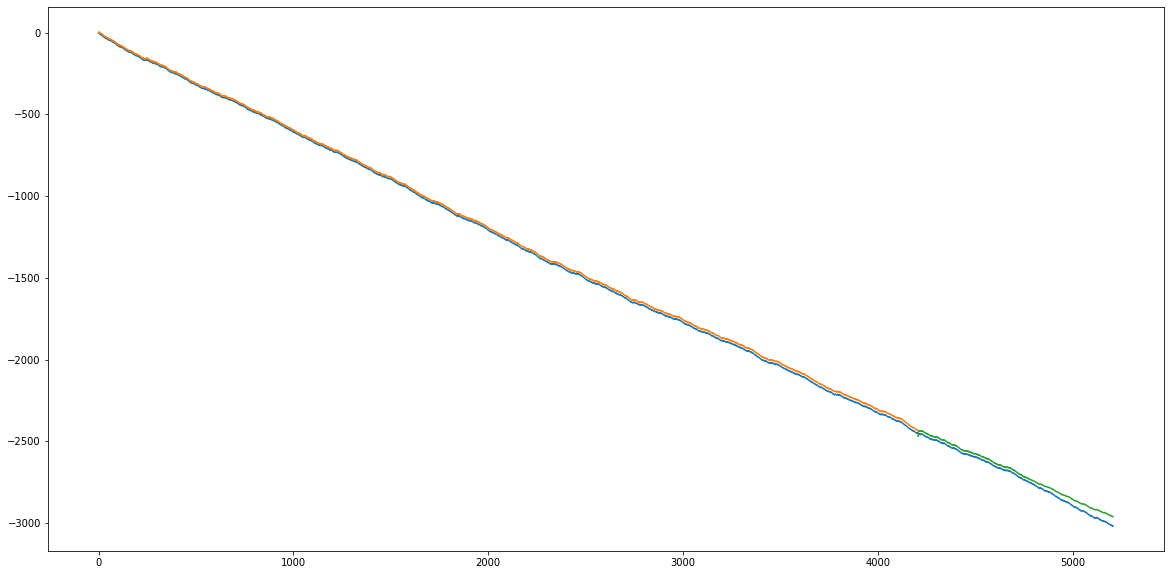

In [ ]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
print(testPredictPlot.shape)

(3208, 1)


In [ ]:
import numpy
numpy.savetxt("pred_lstm.csv", testPredictPlot, delimiter=",")

In [ ]:
print(y_test.shape)

(1, 1001)


In [ ]:
numpy.savetxt("actul_lstm.csv", y_test, delimiter=",")

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
series = read_csv('/content/sunday_csv.csv', header=0, index_col=0)
series_1 = series['node_values']
plot_pacf(series_1, lags = 50)
pyplot.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


FileNotFoundError: ignored